## Morning practical 1 day 5

Here you'll see the problems with high-dimensional data for yourself and experiment with feature selection. First, run the two cells below.

In [1]:
#run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
from numpy.random import default_rng
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display, Markdown
import sklearn
import itertools
from sklearn.datasets import make_blobs

In [2]:
# important functions

def calcEucliDist(vectorOne, vectorTwo):
    return np.linalg.norm(vectorOne-vectorTwo, axis = 1)

def calcAbsDist(vectorOne, vectorTwo):
    #using linalg.norm:
    return np.linalg.norm(vectorOne-vectorTwo, ord = 1, axis = 1)

def makeKMeanClusters(X, k, funName = "calcEucliDist", maxIter = 50, nClusteringsToPerform = 20):
    if k <= 0:
        print("K must be greater than 0!")
        return None
    if k > len(X):
        print("K cannot be larger than the # of samples in your data!")
        return None
    if maxIter <= 0:
        print("Cannot have negative or 0 iterations!")
        return None
    
    resultToReturn = [None, None, None, None]
    bestDistortion = np.Inf
    
    for clusteringIndex in range(0, nClusteringsToPerform):
        initialCentroids   = X[np.random.choice(X.shape[0], k, replace=False), :]
        if len(initialCentroids) != k:
            print("Centroids lost!")
        centroids          = initialCentroids
        threeLastCentroids = []
        #print(centroids)
        for i in range(0, maxIter):

            threeLastCentroids.append(np.round(centroids, 4))
            distancesToCentroids = np.vstack([globals()[funName](centroids, datapoint) for datapoint in X])
            closestCentroid      = np.where(distancesToCentroids == np.amin(distancesToCentroids,
                                                                            axis = 1)[:, np.newaxis])[1]
            centroids            = np.vstack([np.mean(X[np.where(closestCentroid == clusterNum)],
                                                      axis = 0) for clusterNum in np.unique(closestCentroid)])

            if i >2:
                threeLastCentroids.pop(0)
                if np.array_equal(threeLastCentroids[-1],threeLastCentroids[-2]) and np.array_equal(threeLastCentroids[-2], threeLastCentroids[-3]):
                    print("No changes in cluster centroids detected in last 3 iterations. Finished at iteration " + str(i+1) + ".")
                    break
        
        # new code
        squareDistancesPerPoint = []
        for index, centroid in enumerate(closestCentroid):
            squareDistancesPerPoint.append(np.square(centroids[centroid, :] - X[index, :]))
        distortion = 1/len(X) * np.sum(np.array(squareDistancesPerPoint))
        
        if distortion < bestDistortion:
            bestDistortion = distortion
            resultToReturn = [centroids, closestCentroid, initialCentroids, bestDistortion]
                
    return resultToReturn

def hierarCluster(X, distanceFunc = "calcEucliDist", linkageMethod = "average", displayDistMatrix = False):
    
    if linkageMethod not in ["average", "complete", "single"]:
        print("Error, please input a valid linkage method!")
        return None
    if distanceFunc  not in globals().keys():
        print("Error, please input a valid distance function name!")
    
    # make an empty distance matrix
    distanceMatrix = np.zeros(shape = (len(X), len(X)))
    distanceMatrix.fill(np.nan)
    # make a list with the indices of every data point. This is the list of clusters, where you start
    # with every point in a cluster and then start merging them.
    initialList = [[index] for index, _ in enumerate(X)]
    clusterList = initialList.copy()
    clusteringOverIterations = []
    clusteringOverIterations.append(initialList)
    # also make an empty list that saves which cluster indices were merged for every iteration
    clusterIndicesMergedList = []
    for rowIndex, row in enumerate(distanceMatrix):
        for colIndex, cellValue in enumerate(row):
            # distance from yourself to yourself is 0, don't calculate!
            if colIndex == rowIndex:
                continue
            # in the first loop, you calculate distance from 1 to 2.
            # in the second loop, you don't want to calculate distance from 2 to 1 again. This safeguards against that.
            if colIndex < rowIndex:
                continue

            distanceMatrix[rowIndex, colIndex] = globals()[distanceFunc](X[rowIndex,:][np.newaxis,  :],
                                                                             X[colIndex, :][np.newaxis, :])
    if displayDistMatrix:
        display(pd.DataFrame(distanceMatrix))

    # We continue clustering until everything is in one giant cluster. Thats len(X)-1 clustering steps.
    for i in range(0, len(X)-1):
        # we start with no idea of which two clusters we need to cluster
        lowestDistDatapoints = None
        # since we haven't calculated any distance, our current distance is infinite
        distToCluster = np.Inf
        # clusterList initially looks like [[0], [1], ... [99]].
        # itertools.combinations makes that into [([0], [1]), ([0], [2]), ([0], [3]) ... ([1], [2]), ([1], [3])... (98, 99)]
        # so you get all possible combinations of clusters that you could cluster together
        for combo in itertools.combinations(clusterList, 2):

            distance = 0
            distanceSingleLink = np.Inf # need this because for single linkage you want lowest distance to be selected
                                        # so need to have the starting distance always be lower.
            # make all combinations of data points in the first cluster and data points in the second cluster
            # so if the current combo = ([0, 12, 15], [3, 2]), this results in:
            # [[0, 3], [0, 2], [12, 3], [12, 2], [15, 3], [15,2]]: these are all the points that we need to get
            # the distances for (and average for average linkage)
            toIterate = [j for i in [list(zip([elem] * len(combo[1]), combo[1] )) for elem in combo[0]] for j in i]
            for indicesTwoDatapoints in toIterate:
                #sort the indices. Our matrix has only the distance between 1 and 2, not between 2 and 1.
                #this turns [12, 2] from above into [2, 12], etc.
                indicesTwoDatapoints = sorted(indicesTwoDatapoints)

                # keep a running total of all distances between the points in the two clusters
                if linkageMethod == "average":
                    distance += distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "complete":
                    # for a cluster, if the distance between two points is larger than the current largest distance
                    # between points in a cluster, that is the new cluster distance.
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] > distance:
                        distance = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "single":
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] < distanceSingleLink:
                        distanceSingleLink = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]

            if linkageMethod == "average":
                totalAvgDistance = distance/(len(combo[0]) * len(combo[1]))

            # if distance between these clusters is less than the lowest distance we have seen so far,
            #set these clusters as the ones to cluster. 
                if totalAvgDistance < distToCluster:
                    distToCluster       = totalAvgDistance
                    dataPointsToCluster = combo

            if linkageMethod == "complete":
                if distance < distToCluster:
                    distToCluster       = distance
                    dataPointsToCluster = combo

            if linkageMethod == "single":
                if distanceSingleLink < distToCluster:
                    distToCluster       = distanceSingleLink
                    dataPointsToCluster = combo

        #make a new list of clusters
        clusterIndicesMergedList.append(dataPointsToCluster)
        clusterList = clusterList.copy()
        for index, elem in enumerate(clusterList):
            # merge the second cluster into the first cluster
            if elem == dataPointsToCluster[0]:
                clusterList[index] = clusterList[index] + dataPointsToCluster[1]
                #clusterList2[index] = sorted(clusterList[index])
            # remove the separate second cluster (it's now been merged to the first one)    
            if elem == dataPointsToCluster[1]:
                clusterList.pop(index)
        # Finally, save all clusters, from the very beginning (all separate clusters) until the very end (all in one cluster) in one list by appending to that the current clusters      
        clusteringOverIterations.append(clusterList)
        
        #addition to make a list of lists of everything:
        
    
    return [clusteringOverIterations, pd.DataFrame(distanceMatrix), clusterIndicesMergedList]


def drawHierarchicalClustering(hierarClusterOutcome, figsize = (25,8), title = "Plot", labels = None):
    clusterListX       = hierarClusterOutcome[0]
    clusteredPerStepX  = hierarClusterOutcome[2]
    xLabels            = np.array(list(itertools.chain(*clusterListX[-1])))
    
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xticks(range(0, len(xLabels)))
    if not labels is None:
        labels = np.array(labels)
        if len(labels) == len(xLabels):
            labels = labels[xLabels]
            ax.set_xticklabels(labels, rotation = 90)      
        else:
            print("Labels supplied should be of same length as the amount of data points!")
            return None
    else:   
        ax.set_xticklabels(xLabels)
    ax.margins(y=0)

    heightPerDataPointPreviousStep = np.array([0] * len(xLabels))
    for i, clusterStep in enumerate(clusteredPerStepX):
        pos1Positions = np.array([np.where(xLabels == elem)[0] for elem in clusterStep[0]])
        pos1Avg       = np.mean(pos1Positions)
        #pos1Start     = np.min(pos1Positions)
        #pos1End       = np.max(pos1Positions)
        pos1ClustSize = len(pos1Positions)
        pos2Positions = np.array([np.where(xLabels == elem)[0] for elem in clusterStep[1]])
        pos2Avg       = np.mean(pos2Positions)
        #pos2Start     = np.min(pos2Positions)
        #pos2End       = np.max(pos2Positions)
        pos2ClustSize = len(pos2Positions)



        heightEnd   = max(pos1ClustSize, pos2ClustSize)
        ax.plot([pos1Avg, pos1Avg], [heightPerDataPointPreviousStep[pos1Positions[0][0]],heightEnd], color = "black")
        ax.plot([pos2Avg, pos2Avg], [heightPerDataPointPreviousStep[pos2Positions[0][0]],heightEnd], color = "black")
        ax.plot([pos1Avg, pos2Avg], [heightEnd,heightEnd], color = "black")

        heightPerDataPointPreviousStep[np.ravel(pos1Positions)] += heightEnd - heightPerDataPointPreviousStep[pos1Positions[0][0]]
        heightPerDataPointPreviousStep[np.ravel(pos2Positions)] += heightEnd - heightPerDataPointPreviousStep[pos2Positions[0][0]]

    ax.set_ylim(0, max(heightPerDataPointPreviousStep)+1)
    fig.suptitle(title)

    plt.show(fig)

## Seeing how distances become meaningless

One of the strange characteristics of high-dimensional data is that data points become more and more extreme as the number of dimensions rises, yet at the same time the difference between the maximum and minimum distances between points keeps on shrinking so distance metrics become progressively less meaningful. 

Let's make datasets with 2, 5, 10, 100, 1.000, 10.000, 100.000, and 1.000.000 features (dimensions). We'll make three clusters of points in each dataset. It's up to you to calculate the distances between all points in these datasets, and plot the difference between the maximum and minimum distance in each case. To do this:

* For every one of the five datasets in the `dataSetList`:
    * Make a distance matrix (there's 100 data points). Fill it with `np.nan`.
    * Use `itertools.combinations` to get all pairs of data points
    * Use `calcEucliDist` to calculate Euclidean distance between points
    * Save the distance matrices in a list
* When done, get the maximum and minimum entry in each distance matrix (use `np.nanmin`), and calculate the difference between them. Divide this by the minimum distance. Put the outcome in a list.
* Finally, plot the values in this list.

Hints:
* If you get an AxisError saying 'axis 1 is out of bounds for array of dimension 1', try replacing your equivalent of `dataSet[index, :] with dataSet[index, :][np.newaxis, :]`. It's because of shenanigans with the difference between 1D and 2D arrays.

Text(0.5, 0, '# of dimensions (features)')

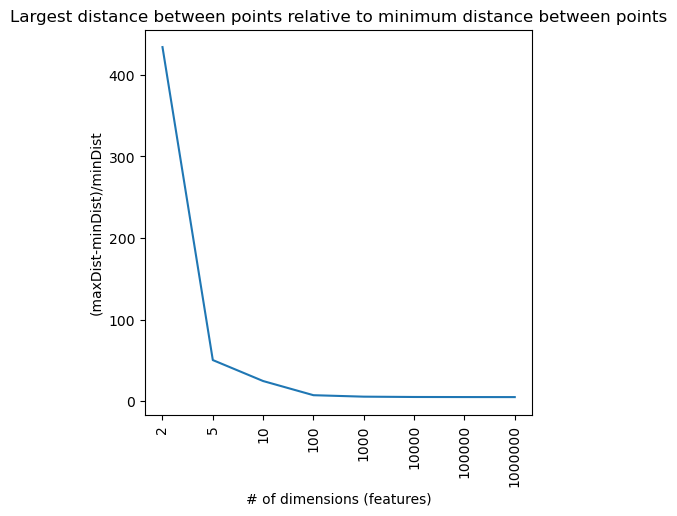

In [3]:
featCountList    = [2, 5, 10, 100, 1000, 10000, 100000, 1000000]
dataSetList      = []
clusterLabelList = []

for featCount in featCountList:
    X, y = sklearn.datasets.make_blobs(n_samples = 100, n_features = featCount, centers = 3, random_state = featCount)
    dataSetList.append(X)
    clusterLabelList.append(y)

# your answer here. Don't need to use the labelList.
    
# answer

distMatList  = []
distDiffList = []
for dataSet in dataSetList:
    distMat = np.zeros(shape=(len(dataSet), len(dataSet)))
    distMat.fill(np.nan)
    for pointOneIndex, pointTwoIndex in itertools.combinations(range(len(dataSet)), 2):
        distance = calcEucliDist(dataSet[pointOneIndex, :][np.newaxis, :],
                                 dataSet[pointTwoIndex, :][np.newaxis, :]).item()
        distMat[pointOneIndex, pointTwoIndex] = distance
    distMatList.append(distMat)
    minimum = np.nanmin(distMat)
    distDiffList.append((np.nanmax(distMat) - minimum) / minimum)
    
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(list(range(len(distDiffList))), distDiffList)
ax.set_title("Largest distance between points relative to minimum distance between points")

# Set tick locations and labels correctly to avoid warnings
ax.set_xticks(range(len(distDiffList)))
ax.set_xticklabels(featCountList, rotation=90)

ax.set_ylabel("(maxDist-minDist)/minDist")
ax.set_xlabel("# of dimensions (features)")
        

## 

## Problems with overfitting in high dimensionality

The intuition would be that more features is better: the more features, the easier to separate classes, say, or predict housing problems. The issue is that for more features you need exponentially more data to cover all your bases, to make sure you have a good coverage of the possible values for each feature. If you don't do that, you are very prone to overfitting. The simplest case can be illustrated with 2 dimensions: 1 dimension which is informative for class membership, and one which we add and is just completely random noise. The addition of the random noise suddenly allows us to get perfect separation, but we know that this is just a result of not having enough samples to see that the 2nd dimension is useless: ![overfitting](overfittingDueToDims.PNG)

Let's experience these problems for ourselves. We'll make 11 datasets for classification, where 2 features are informative and the rest are just random. We'll keep the number of samples at 1.000. We'll train logistic regression (using the sklearn implementation, unregularised) on a train set and test on the test set, and see how well we do on train and test in each case. I make the ten datasets below, up to you to:
* Split into train and test set for each case (80/20). Use a random state of 42. (Normally you'd do cross-validation or even nested cross-validation, but for this example we don't need to go so far).
* Train a logistic regression classifier (without regularisation!) in each case.
* Get the performance on the training data and the test data.
* Plot performance on the training data and on the test data in the same plot (with _n\_dimensions_ on the x-axis, and accuraccy on the y-axis)

0
1
2
3
4
5
6
7
8
9
10


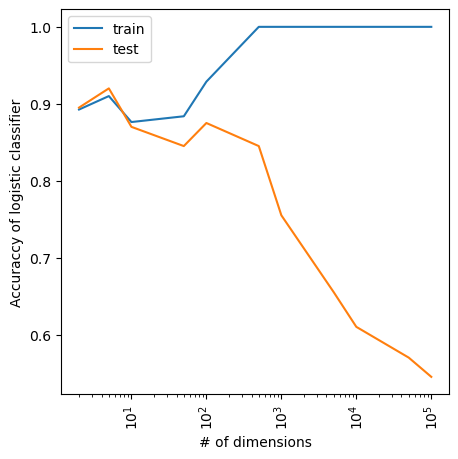

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
featuresToMake    = [2, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
classDataSetsList = []
classLabelList    = []
for nFeats in featuresToMake:
    X, y = sklearn.datasets.make_classification(n_samples = 1000, n_features = nFeats, n_informative = 2,
                                               n_redundant = 0, n_classes = 2, random_state=nFeats)
    classDataSetsList.append(X)
    classLabelList.append(y)
    
    
# answer

train_acc = []; test_acc = []
for index, dataSet in enumerate(classDataSetsList):
    print(index)
    X_train, X_test, y_train, y_test = train_test_split(dataSet, classLabelList[index], test_size = 0.2, random_state = 42)
    regressor = LogisticRegression(penalty = None)
    regressor.fit(X_train, y_train)
    train_acc.append(regressor.score(X_train, y_train))
    test_acc.append(regressor.score(X_test, y_test))
    
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(featuresToMake, train_acc, label = "train")
ax.plot(featuresToMake, test_acc, label  = "test")
ax.legend()
ax.set_ylabel("Accuraccy of logistic classifier")
ax.set_xticks([0] + featuresToMake)
ax.set_xticklabels([0] + featuresToMake, rotation = 90)
ax.set_xlabel("# of dimensions")
ax.set_xscale("log", base=10)

## Feature selection

As you'll have seen, you're doing an absolutely stellar job on the training data from 998 noise features onwards, but performing abominably on the test set. How do we combat this? One option is to use dimensionality reduction methods, of which we'll discuss the most well-known one in the following lecture. Another option is to use feature selection. 

## Forward selection using filtering

First, let's use the filter method, where you use some other criterion outside of the ML training and testing workflow to pre-determine which features to include. Below, I give you the case where you have 1000 features to work with. Your job: filter the data using t-tests between the mean of class 1 and class 2, and select the top 2 features. Then, train a classifier on those and see the results. **Note that you should only perform feature selection on the training set to prevent overfitting**.

Hints:
* You need to do a t-test for each feature (column), and between the rows corresponding to class 1 (y=0) and class 2 (y=1)
* The highest difference implies the largest absolute t-statistic
* You'll probably need to sort the absolute t-statistics, pick the two largest ones, and then pick the features that had that t-statistic.
* This is one of few times I didn't give an itemised to-do list. If you feel lost, though, feel free to ask or look in the answers!

In [5]:
from scipy.stats import ttest_ind
X, y = classDataSetsList[6], classLabelList[6]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# your answer here

# answer
tTestStatPerFeat = []; pValPerFeat = []
for featNr in range(0, X.shape[1]):
    classOneSamples = X_train[np.where(y_train == 0)[0], featNr]
    classTwoSamples = X_train[np.where(y_train == 1)[0], featNr]
    tStatistic, pVal = ttest_ind(classOneSamples, classTwoSamples)
    tTestStatPerFeat.append(tStatistic); pValPerFeat.append(pVal)

absTSorted = np.sort(np.abs(tTestStatPerFeat))
largestTStatistics = absTSorted[-2:]
indicesBestFeats = []
for statistic in largestTStatistics:
    indicesBestFeats.append(np.where(np.logical_or(tTestStatPerFeat == statistic, tTestStatPerFeat == -statistic))[0][0])

print("Indices of the best two features: " + str(indicesBestFeats))
filtered_X_train = X_train[:, indicesBestFeats]
filtered_X_test  = X_test[:, indicesBestFeats]

filtRegressor = LogisticRegression(penalty = None)
filtRegressor.fit(filtered_X_train, y_train)
print("Scores on filtered features")
print("train: " + str(filtRegressor.score(filtered_X_train, y_train)))
print("test: " + str(filtRegressor.score(filtered_X_test, y_test)))

# compare with unfiltered performance:
regressor = LogisticRegression(penalty = None)
regressor.fit(X_train, y_train)
print("Scores on unfiltered features")
print("train: " + str(regressor.score(X_train, y_train)))
print("test: " + str(regressor.score(X_test, y_test)))


Indices of the best two features: [457, 488]
Scores on filtered features
train: 0.9075
test: 0.925
Scores on unfiltered features
train: 1.0
test: 0.755


## Conclusion filtering

If all went well, you should see that there's a pretty sizeable increase in performance on the test set: for me, it went from 0.75% accuracy to 0.925% accuracy. Of course, using a t-test is pretty basic, and in reality features won't be either _very_ informative or random. Still, the procedure is the same. Note also that there are (many) other approaches, such as using mutual information (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) and [here](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)).

## Wrappers for feature selection

In the end, the proof is in the pudding: we don't care about t-test statistics or mutual information, they are a _proxy_ for how well the feature will serve us in our classification or prediction task. Another option is to just brute-force things: if we care about how our classifier performs, then surely the best course of action is simply to see how our classifier performs for certain features. To do this, we train a separate classifier for each feature, pick the one that performs best in cross-validation, then train a classifier using that best feature plus every other feature, again pick the feature that performs best in cross-validation, etc. We stop when we note that when adding more features our performance actually goes down.

Note that this involves a _lot_ of training and testing: for 1000 features you're training 1000 classifiers (k times because you are doing cross-validation), then 999 classifiers (k times), then 998 classifiers (k times), etc. Let's do feature selection using such a wrapper right now. We'll use a dataset with fewer features: only a 100, of which 2 are informative again. Up to you to:

* Train a logistic regression classifier (without regularisation) for each feature separately (using 5-fold cross-validation and sklearn (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)))
* Record for each feature the average ROC AUC (score) over the 5 test folds. 
* Pick the feature with the highest average score for inclusion.
* Now train all combinations of that feature with one other feature, again record the average ROC AUC over folds.
* If the average ROC AUC on the test set is higher, add the new feature as well. If not (adding more features only brings down performance): stop.

Hints:
* Do your thang with the X_train and y_train data, we're keeping one final test set separate to know our final performance.
* If you get problems when subsetting, use something like `X_train[:,colIndex][:, np.newaxis]`. Otherwise it's a 1D-array and sklearn doesn't like that. **Do this only in case the shape is wrong, don't always add dimensions like this!**
* Cross-validation gives you back a dictionary, you'll want the `["test_score"]` part of it.
* Doing this is not entirely trivial, you'll need two loops, and to check whether the current result is better than the previous one, etc. If you get stuck, you know what to do!

In [6]:
X, y = classDataSetsList[4], classLabelList[4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


# answer
logRegressor = LogisticRegression(penalty = None)
selectedFeatIndices      = []
selectedClassifierScores = []
# we'll do the procedure a maximum of 1000 times, but actually stop the procedure as soon as
# the cross-validation performance goes down when including a new feature
for i in range(0, X_train.shape[1]):
    print("iteration " + str(i) + " out of a max of " + str(X_train.shape[1]))
    avgCrossValScoreList = []
    for colIndex in range(0, X_train.shape[1]):
        # if there are already features, take the current feature + the already selected features
        if not colIndex in selectedFeatIndices:
            featsToSelect = [colIndex]; featsToSelect += selectedFeatIndices
            result   = sklearn.model_selection.cross_validate(logRegressor, X_train[:,featsToSelect], y_train,
                                                        scoring = "roc_auc", cv = 5)
            avgScoreTheseFeats = np.mean(result["test_score"])
            avgCrossValScoreList.append(avgScoreTheseFeats)
        else:
            # adding the same feature again should have 0 information.
            avgCrossValScoreList.append(0)
        
    bestPerformingFeatAvgScore = np.max(avgCrossValScoreList)
    selectedClassifierScores.append(bestPerformingFeatAvgScore)
    selectedFeatIndices.append(np.where(avgCrossValScoreList == bestPerformingFeatAvgScore)[0][0])
    
    #now, check if the performance went up relative to the last entry
    if i >= 1:
        print("new score avg: " + str(bestPerformingFeatAvgScore))
        thisComboFeatsScore     = bestPerformingFeatAvgScore
        previousComboFeatsScore = selectedClassifierScores[-2]
        print("previous score avg: " + str(previousComboFeatsScore))
        if thisComboFeatsScore < previousComboFeatsScore:
            finalSelectedFeatureIndices       = selectedFeatIndices[0:-1] #remove the last entry, because it only made things worse
            finalSelectedFeatComboPerformance = selectedClassifierScores[-2]
            break #stop the procedure, we have our features

print("Indices of final selected features: " + str(finalSelectedFeatureIndices))
print("Final performance: " + str(finalSelectedFeatComboPerformance))

iteration 0 out of a max of 100
iteration 1 out of a max of 100
new score avg: 0.9508069522581654
previous score avg: 0.9487755850523518
iteration 2 out of a max of 100
new score avg: 0.9523383096968276
previous score avg: 0.9508069522581654
iteration 3 out of a max of 100
new score avg: 0.9532446085325832
previous score avg: 0.9523383096968276
iteration 4 out of a max of 100
new score avg: 0.9536196476011878
previous score avg: 0.9532446085325832
iteration 5 out of a max of 100
new score avg: 0.9543696817862166
previous score avg: 0.9536196476011878
iteration 6 out of a max of 100
new score avg: 0.9549634806219721
previous score avg: 0.9543696817862166
iteration 7 out of a max of 100
new score avg: 0.9554322989920301
previous score avg: 0.9549634806219721
iteration 8 out of a max of 100
new score avg: 0.9562449161978435
previous score avg: 0.9554322989920301
iteration 9 out of a max of 100
new score avg: 0.9569324699171744
previous score avg: 0.9562449161978435
iteration 10 out of a m

## Conclusion wrapper

It depends on exactly what you did, what the result is (you don't say?). If you allow the same feature to be selected multiple times, then that does indeed happen. I got feature 18 in there a whopping 18 times, for instance. So you shouldn't allow this: apparently having the same feature multiple times somehow can improve performance, but you know that any performance gain is fake: it's just the same feature repeated, after all!

When you don't allow duplicate features, things are still somewhat strange: I get 13 features selected, while there should be only 2 features informative for class membership. This shows you how there's still the problem of not having enough training data even if we do feature selection: by chance, some of the completely random features might _seem_ to have some relation to class membership, because some observations with class 1 got a few slighly higher values for a certain feature than those in class 0. If you'd have 1.000.000.000 training examples, this effect would be less likely to exist. If you look at the output in the answers, you do see that 1 feature gets you up to 0.945 ROC AUC, adding the second gets you to 0.951 ROC AUC, and all the others only bring it to a ROC AUC of 0.958. So we could solve this by only accepting extra features that give, say, > 0.005 increase in AUC ROC. 

What you must have noticed is that this is computationally much more expensive. In reality, you could mix and match these strategies: first remove features that have almost no variance (they contain basically no information), then filter on some criterion but be quite lenient in how many features you still allow, and then use wrapping for final selection.

## Conclusion forward feature selection

Of course, methods like these are all _greedy_: you just select the _n_ features that, on their own, have the most difference between classes in some metric (filtering) or that, on their own, contribute most to increasing classification performance in combination with previously selected features (wrapper). However, it's not difficult to see that 10 individually not that informative features could, when combined, uniquely identify each class really well. You saw a hypothetical example of this in the lecture. Hence, these methods are not the end-all be-all, and more sophisticated methods exist. We won't go into those here. What we will go into is dimensionality reduction, which aims at compressing the variance/information in many dimensions into fewer ones as best as possible, to avert the dimensionality problems in that way.

## Note on embedded methods

There's a third class of methods: the ones like L1 regularisation, where the weights for certain features shrink to 0 during training, so that there's automatic feature selection. This, too, will prevent overfitting, and is the reason why I expressly dictated that there should be no regularisation in your logistic regressors. Another example of this would be feature selection in Random Forests based on the feature importance (which RFs automatically calculate for each 
feature).

## What I'd like you to remember here:
* High-dimensional data has wacky properties: distances become meaningless/dominated by noise, and data becomes _incredibly_ sparse very quickly. The amount of data you need to cover the feature space well rises exponentially with the number of features.
* High-dimensional data makes it easy to overfit. This is directly related to the previous point: only if you have huge swathes of data (unrealistically, unobtainably huge) can you hope to cover the feature space well. Otherwise, you will suddenly find perfect hyperplanes or other separations of the data, that are really just based on noise and don't hold up in test sets.
* Besides dimensionality reduction, which we'll tackle next, you can also perform feature selection. This (or at least the basic greedy forward feature selection methods we discuss here) is not guaranteed to give you the best _combination of features_ for prediction. Rather, you use some external numerical property (filter) or classifiers trained with individual best features added each time (wrapper), and keep adding features until performance goes down. Regularisation, especially with the L1 norm, gives an automatic way of performing feature selection.

## The end
No Ender dragon here. Only the prospect of another lecture. Congrats on being done with this practical! Oh and don't forget to shoot me your thoughts (be they positive or unholy):

## Survey
[You know the drill](https://docs.google.com/forms/d/e/1FAIpQLSdhDoOGetpgKehesdRMDp4y_KlSVhy8oQIcKMAaOEya3d6LwQ/viewform?usp=sf_link)
